In [26]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits 
import glob


from scipy import interpolate
from funcs.ad import sample_AD_for_custom_distribution, get_pvalue_from_AD_statistic

import lightkurve as lk

import pandas as pd

def get_observed_phases(p, lcs, cadences, qcs, phaseshift=0.):
    """Takes 
    
    ps, bins = get_observed_phases(np.sort(pss), lcs, [2,2,2,10./60.], [11, 38, 64,1], phaseshift=phaseshift)#

    
    Parameters:
    -----------
    mode : str
        either "Rotation" or "Orbit"
    p : array
        array of phases, for the KS-test it should be the 
        measured flare phases, for the AD test, any well 
        sampled grid of phases works
    phaseshift : float
        default = 0
        
    Return:
    -------
    pandas.DataFrame - one column per Sector or Quarter,
                       and observing time per phase in each row
    list - mids of bins for each phase row in the DataFrame
    """
    
    # bin array is two elements longer than the number of bins
    # to include 0 and 1
    bins = p 
    # add zero and one
    bins = np.concatenate([bins, [1]])
    bins = np.concatenate([[0], bins])
#     print(bins)
    phases = pd.DataFrame()
#     plt.figure(figsize=(8, 3))
    for q, cadence, ph in list(zip(qcs, cadences, lcs)):
        

        counts, bins = np.histogram((ph + phaseshift) % 1, bins=bins)
            
        # get observing times for each Sector
        phases[q] = counts * cadence
    print(phases)

    return phases, (bins[1:] + bins[:-1])/2



def get_cumulative_distributions(df, dfphases, sectors, F_k_cheops):
    """Calculate the cumulative distribution function of observed
    flares, while accounting for the number of observed flares in
    a light curve with a given detection threshold.

    Parameters:
    -----------
    df : DataFrame
        detected flares table, with a flag qcs that denotes the LC
    dfphases : DataFrame
        table that lists the observed phases, with a column for each LC
    get_secs_cadences : list
        format: [(Sector, cadence in minutes), (.., ..), (.., ..)]
        Sector is an int
        cadence is a float
    """
    # Measured number of flares in each bin
    F = dfphases.shape[0]
    n_i = np.full(F, 1)

    # Calculate cumulative frequency distribution
    cum_n_i = np.cumsum(n_i) / F

    # Expected number of flares in each bin

    # setup array for each bin
    n_exp = np.zeros_like(n_i).astype(float)

    # sum over different sectors to account for different detection thresholds
    for sec in sectors:
        obstimes_k = dfphases[sec]
        # print(obstimes_k)
        tot_obstimes_k = obstimes_k.sum() # total observation time in that Sector in minutes
        # print(tot_obstimes_k)
        if sec == 1:
            F_k = F_k_cheops
        else:   
            F_k = df[df.qcs==sec].shape[0] # number of flares in that Sector


        # print(F_k)
        n_exp_k = (obstimes_k * F_k / tot_obstimes_k).values 
        # print(n_exp_k)
        n_exp += n_exp_k
        # print(n_exp)
    # for debugging: 
    # calculate the old cumulative distribution that 
    # ignores the different detection thresholds
    # cum_n_exp_alt = dfphases.sum(axis=1).values.cumsum() / dfphases.sum(axis=1).values.sum()
    
    # Calculate cumulative frequency distribution
    cum_n_exp = n_exp.cumsum() / n_exp.sum()
    
    return n_i, n_exp, cum_n_exp, cum_n_i#, cum_n_exp_alt return alternative only if necessary


,date,newmed,amplitude,t_peak_BJD,dur_d,amplitude2,t_peak_BJD2,dur_d2,ED,EDerr,mean_bol_energy,std_bol_energy,ingress,egress,tmin,tmax,parametrization,tot_obs_time_d,phase
0,20240415114752,2.463032e+06,4188.419774,2.460413e+06,0.030912,NaN,NaN,NaN,2.09,0.233,6.494166996961426e+33 erg,8.874449071302292e+32 erg,2.460413e+06,NaN,2460413.175,2460413.20,davenport2014,0.174306,0.955230
1,20240529072301,2.492243e+06,9879.207629,2.460456e+06,0.021951,NaN,NaN,NaN,4.86,0.296,1.4906041750484522e+34 erg,1.5745692283025478e+33 erg,NaN,2.460455e+06,2460455.630,2460455.67,davenport2014,0.300347,0.055400
2,20240410135336,2.565071e+06,31787.034053,2.460400e+06,0.028275,NaN,NaN,NaN,24.60,0.583,7.558613035634906e+34 erg,6.622868258540838e+33 erg,NaN,2.460400e+06,2460399.970,2460400.09,davenport2014,0.321875,0.061496
3,20240325102059,2.522340e+06,130290.487307,2.460393e+06,0.054068,138748.127497,2.460393e+06,0.010392,236.00,9.420,7.309389286702922e+35 erg,6.9660371380047725e+34 erg,NaN,2.460393e+06,2460392.760,2460392.93,davenport2014,0.317940,0.024634


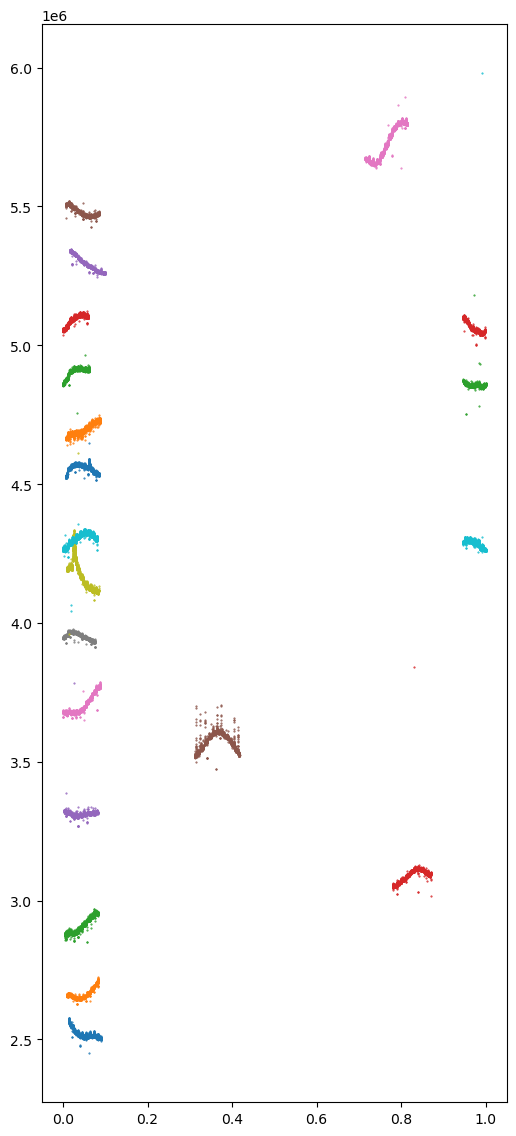

In [2]:
files = glob.glob('../data/hip67522/CHEOPS-products-*/Outdata/00000/hip67522_CHEOPS-products-*_im.fits')


cheops_phases = np.array([])
midpoint = 2460392.61598
period = 6.959503
# period = 1.44
offs =0
plt.figure(figsize=(6,14))

time = np.array([])
flux = np.array([])

for file in files:
    hdulist = fits.open(file)


    # get the image data
    image_data = hdulist[1].data

    t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

    # make sure the data is in fact 10s cadence
    assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

    # big endian to little endian
    t = t.byteswap().newbyteorder()
    f = f.byteswap().newbyteorder()
    ferr = ferr.byteswap().newbyteorder()
    roll = roll.byteswap().newbyteorder()

    time = np.concatenate([time, t])
    flux = np.concatenate([flux, f])


    # convert t to phase
    phase = ((t - midpoint) % period) / period


    cheops_phases = np.concatenate([cheops_phases, phase])

    plt.plot(phase, f+offs, ".", markersize=1)
    offs += 200000
    # plt.xlim(0,0.1)
    # plt.ylim(2.25e6, 2.8e6)

cheopsflares = pd.read_csv("../results/cheops_flares.csv")
cheopsflares["phase"] = ((cheopsflares.t_peak_BJD - midpoint) % period) / period
cheopsflares

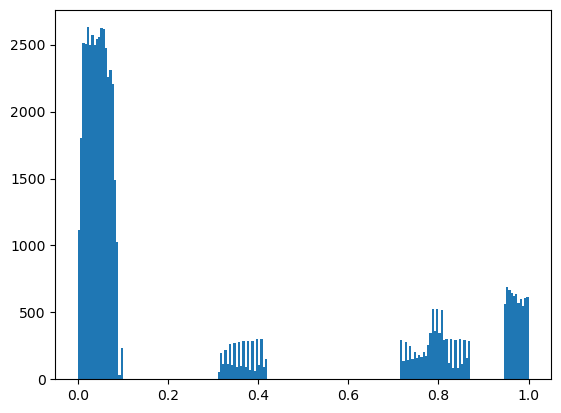

In [3]:
plt.hist(cheops_phases.flatten(), bins=200);

/tmp/ipykernel_4601/2880837156.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lclist = lk.search_lightcurvefile("HIP 67522", mission="TESS", author="SPOC", exptime=120)


[36437.31  36417.016 36444.535 36482.715 36436.926 36439.105 36446.793
 36481.168 36449.71  36493.246 36481.633 36516.004 36497.82  36494.496
 36462.637 36462.184 36475.953 36500.387 36499.6   36516.645] electron / s
[36293.867 36160.22  36161.996 36170.188 36204.656 36189.188 36175.54
 36189.637 36177.29  36165.29  36185.938 36168.375 36207.71  36180.074
 36154.12  36205.15  36254.312 36231.535 36211.07  36255.254] electron / s
[35229.457 35251.945 35267.566 35288.07  35267.7   35271.38  35254.426
 35282.39  35297.484 35267.83  35257.844 35259.62  35251.45  35226.855
 35270.43  35265.    35227.87  35321.11  35219.42  35266.777] electron / s


Text(0, 0.5, 'Normalized Flux')

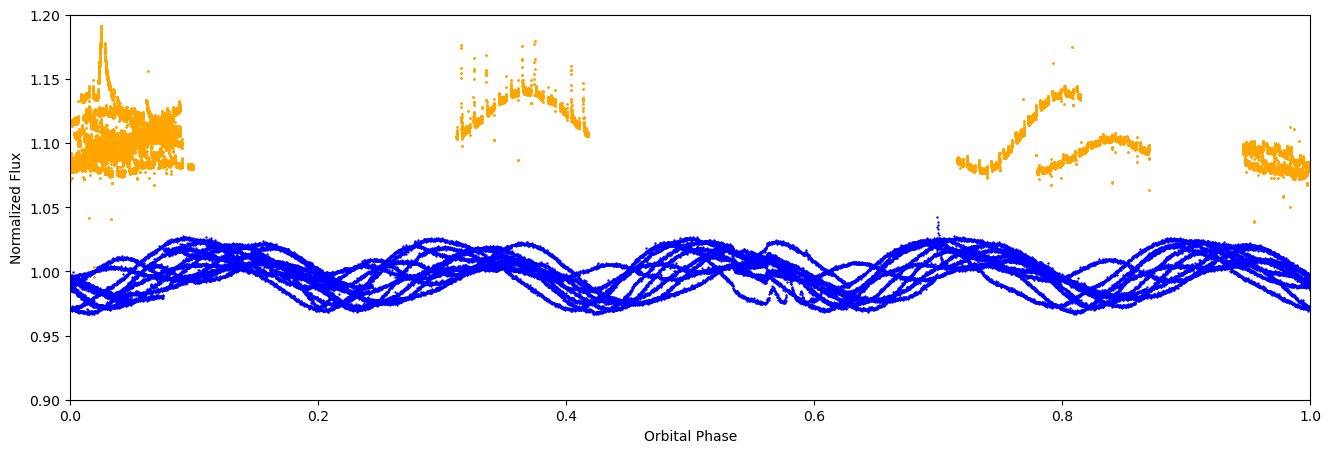

In [56]:
lclist = lk.search_lightcurvefile("HIP 67522", mission="TESS", author="SPOC", exptime=120)

midtime = 2458604.02358

period = 6.959503
plt.figure(figsize=(16,5))
for entry in lclist:
    lc = entry.download().remove_outliers()
    phases = (lc.time.value - midtime) % period / period
    
    print(lc.flux[:20])
    plt.scatter(phases, lc.flux.value/np.nanmedian(lc.flux.value), s=0.5, c="blue")

    plt.scatter(cheops_phases, flux/np.nanmedian(flux)+0.1, s=0.5, c="orange")

plt.ylim(0.9,1.2)
plt.xlim(0,1)
plt.xlabel("Orbital Phase")
plt.ylabel("Normalized Flux")

In [ ]:
# plot phase vs. flux for TESS light curves
plt.figure(figsize=(6,14))
offs = 0

for entry in lclist:
    lc = entry.download().remove_outliers()
    phases = (lc.time.value - midtime) % period / period

    plt.scattter(phases, lc.flux.value)

plt.

In [5]:
lcs.append(cheops_phases)
lcs

[array([0.00483561, 0.00503518, 0.00523475, ..., 0.40363668, 0.40383624,
        0.40403581]),
 array([0.46391657, 0.46411613, 0.4643157 , ..., 0.24346134, 0.2436609 ,
        0.24386046]),
 array([0.07526688, 0.07546646, 0.07566603, ..., 0.62763256, 0.62783213,
        0.6280317 ]),
 array([0.01439838, 0.01441505, 0.01443172, ..., 0.81463956, 0.81465623,
        0.8146729 ])]

       11     38     64           1 
0     466    700    516  1135.333333
1     212    284    212   590.833333
2     136    188    140   396.666667
3     318    444    324   932.000000
4     120    160    118   334.000000
5     326    440    202   954.333333
6      52     76     18   166.166667
7     126    170     44   353.500000
8    1968   2040   1234  1889.500000
9    1486   1500   1508     0.000000
10   1982   1958   1980     0.000000
11  11890  12930  16556   639.500000
12   2338   4680   3664   112.333333
13   1648   3304   2480   767.833333
14   2682   5464   4096   479.500000
15    144    288    216   163.166667
16    890   1800   1330   913.333333
Obs time
11    26784.0
38    36426.0
64    34638.0
1      9828.0
dtype: float64
[0.         0.01754594 0.02463418 0.02932041 0.04032543 0.04435866
 0.05540023 0.05725983 0.06149628 0.11246682 0.15009205 0.19953866
 0.6125841  0.72928557 0.81175128 0.94801832 0.95522964 1.        ]


100%|██████████| 20000/20000 [00:16<00:00, 1189.89it/s]


20000 (20000,)
0.00460000000000008 5.370719731809473
KstestResult(statistic=0.41450781167964723, pvalue=0.0025845400520368754, statistic_location=0.19953865701349285, statistic_sign=1)
       11     38     64           1 
0     466    700    516  1135.333333
1     212    284    212   590.833333
2     136    188    140   396.666667
3     318    444    324   932.000000
4     120    160    118   334.000000
5     326    440    202   954.333333
6      52     76     18   166.166667
7     126    170     44   353.500000
8    1968   2040   1234  1889.500000
9    1486   1500   1508     0.000000
10   1982   1958   1980     0.000000
11  11890  12930  16556   639.500000
12   2338   4680   3664   112.333333
13   1648   3304   2480   767.833333
14   2682   5464   4096   479.500000
15    144    288    216   163.166667
16    890   1800   1330   913.333333
Obs time
11    26784.0
38    36426.0
64    34638.0
1      9828.0
dtype: float64
[0.         0.01754594 0.02463418 0.02932041 0.04032543 0.04435866
 0

100%|██████████| 20000/20000 [00:16<00:00, 1190.25it/s]


20000 (20000,)
0.0010999999999998522 5.370719731809473
KstestResult(statistic=0.41450781167964723, pvalue=0.0025845400520368754, statistic_location=0.19953865701349285, statistic_sign=1)
       11     38     64           1 
0     466    700    516  1135.333333
1     212    284    212   590.833333
2     136    188    140   396.666667
3     318    444    324   932.000000
4     120    160    118   334.000000
5     326    440    202   954.333333
6      52     76     18   166.166667
7     126    170     44   353.500000
8    1968   2040   1234  1889.500000
9    1486   1500   1508     0.000000
10   1982   1958   1980     0.000000
11  11890  12930  16556   639.500000
12   2338   4680   3664   112.333333
13   1648   3304   2480   767.833333
14   2682   5464   4096   479.500000
15    144    288    216   163.166667
16    890   1800   1330   913.333333
Obs time
11    26784.0
38    36426.0
64    34638.0
1      9828.0
dtype: float64
[0.         0.01754594 0.02463418 0.02932041 0.04032543 0.04435866


100%|██████████| 20000/20000 [00:16<00:00, 1194.29it/s]


20000 (20000,)
0.003100000000000023 5.370719731809473
KstestResult(statistic=0.41450781167964723, pvalue=0.0025845400520368754, statistic_location=0.19953865701349285, statistic_sign=1)
       11     38     64           1 
0     466    700    516  1135.333333
1     212    284    212   590.833333
2     136    188    140   396.666667
3     318    444    324   932.000000
4     120    160    118   334.000000
5     326    440    202   954.333333
6      52     76     18   166.166667
7     126    170     44   353.500000
8    1968   2040   1234  1889.500000
9    1486   1500   1508     0.000000
10   1982   1958   1980     0.000000
11  11890  12930  16556   639.500000
12   2338   4680   3664   112.333333
13   1648   3304   2480   767.833333
14   2682   5464   4096   479.500000
15    144    288    216   163.166667
16    890   1800   1330   913.333333
Obs time
11    26784.0
38    36426.0
64    34638.0
1      9828.0
dtype: float64
[0.         0.01754594 0.02463418 0.02932041 0.04032543 0.04435866
 

100%|██████████| 20000/20000 [00:17<00:00, 1154.17it/s]


20000 (20000,)
0.004399999999999977 5.370719731809473
KstestResult(statistic=0.41450781167964723, pvalue=0.0025845400520368754, statistic_location=0.19953865701349285, statistic_sign=1)


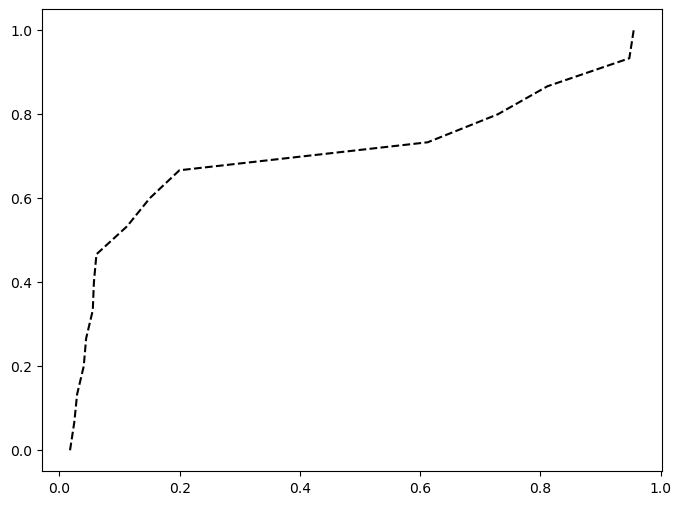

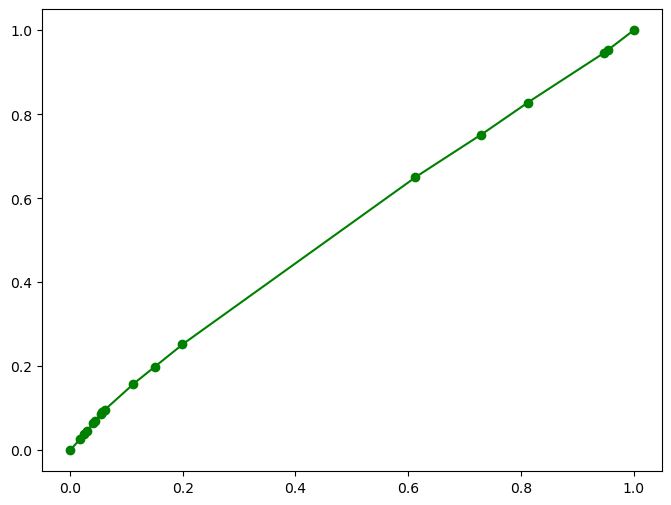

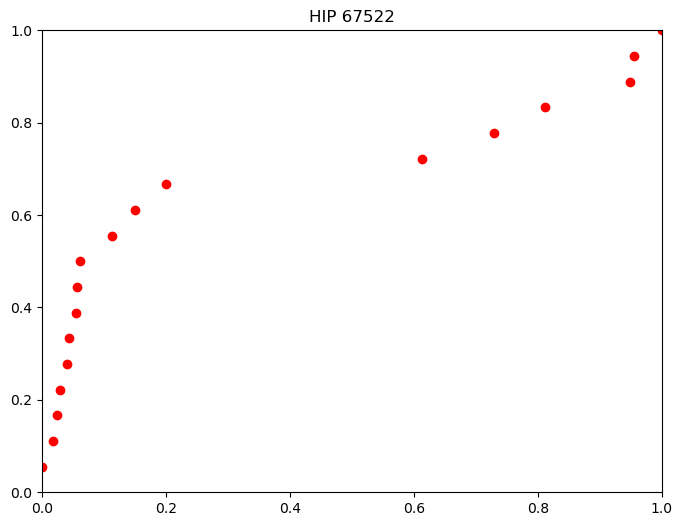

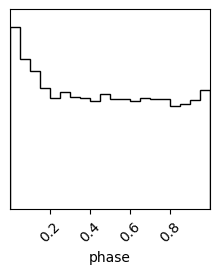

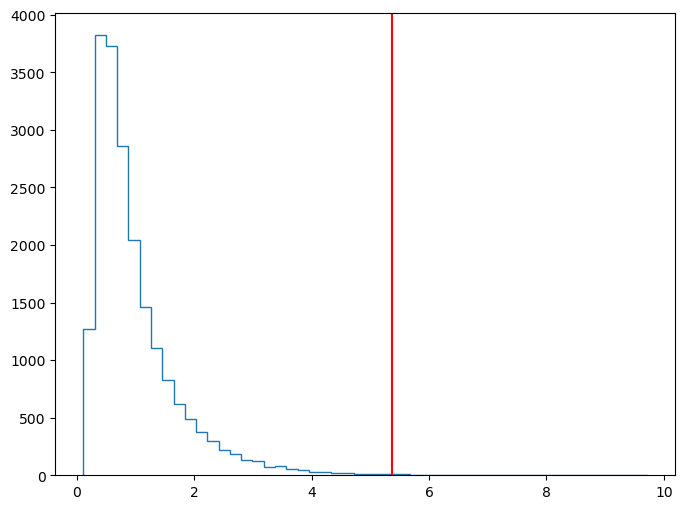

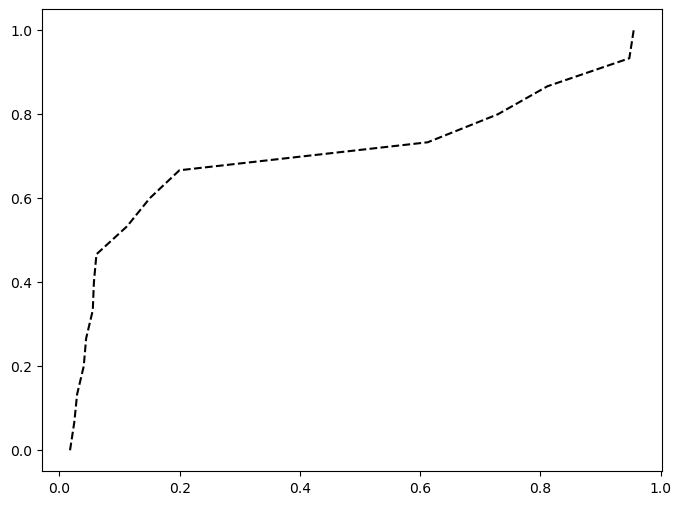

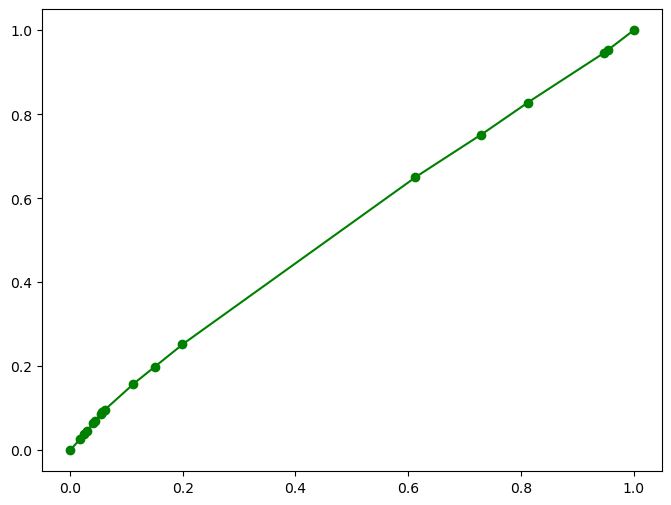

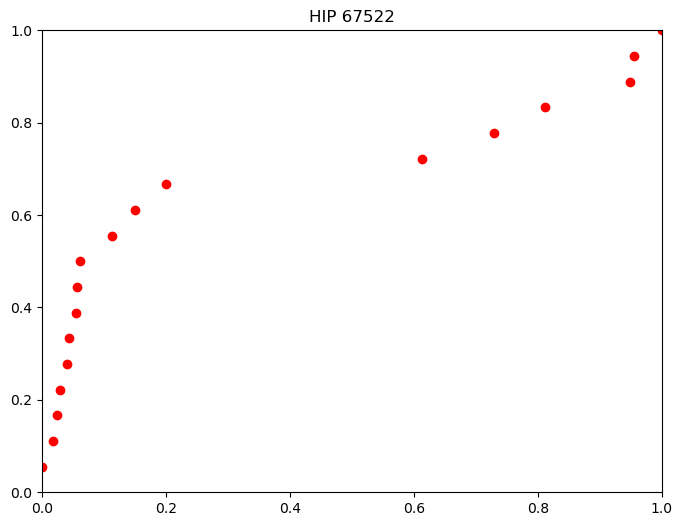

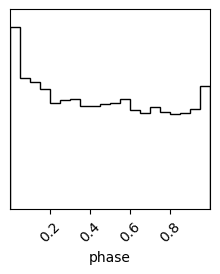

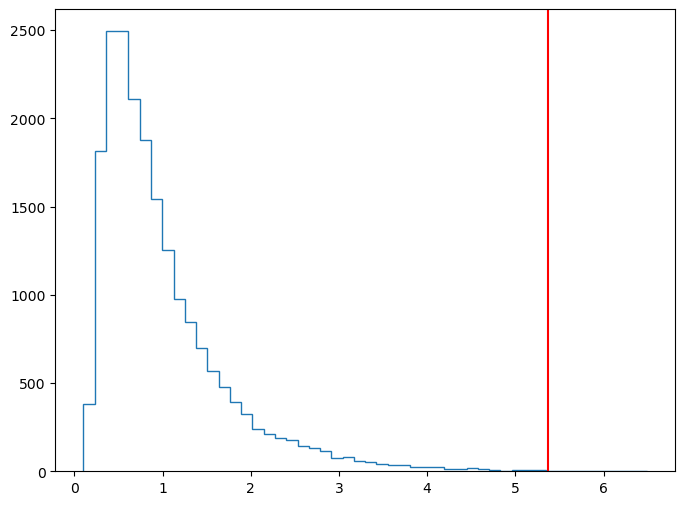

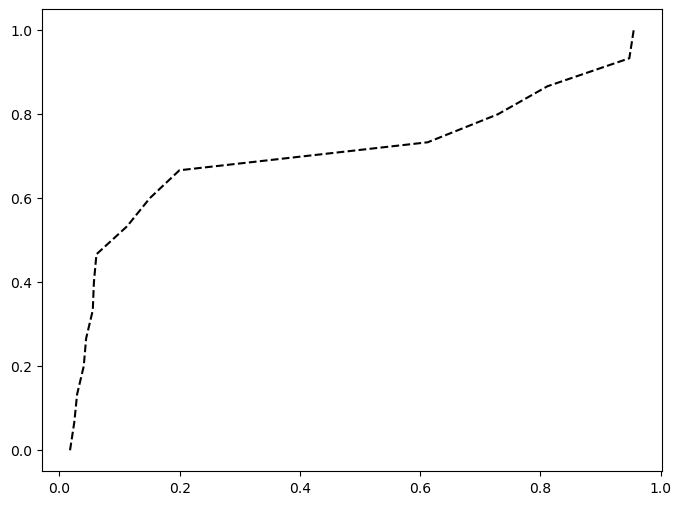

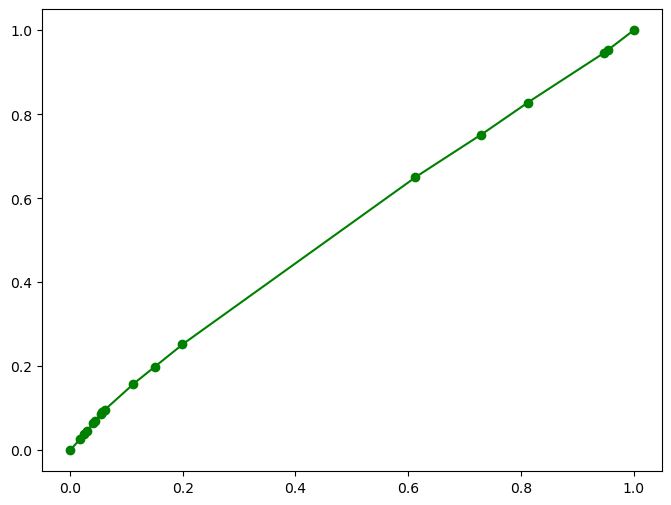

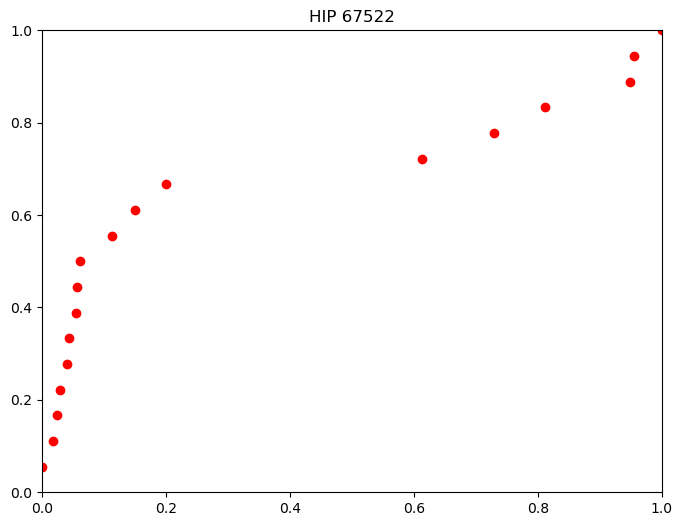

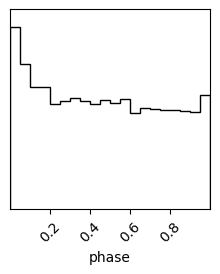

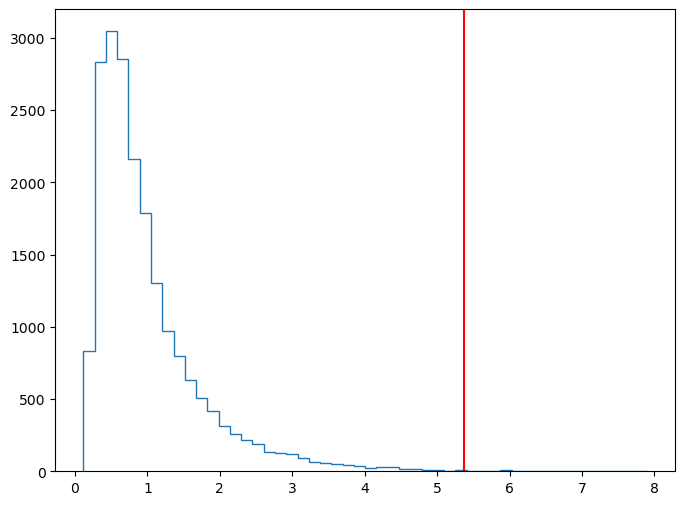

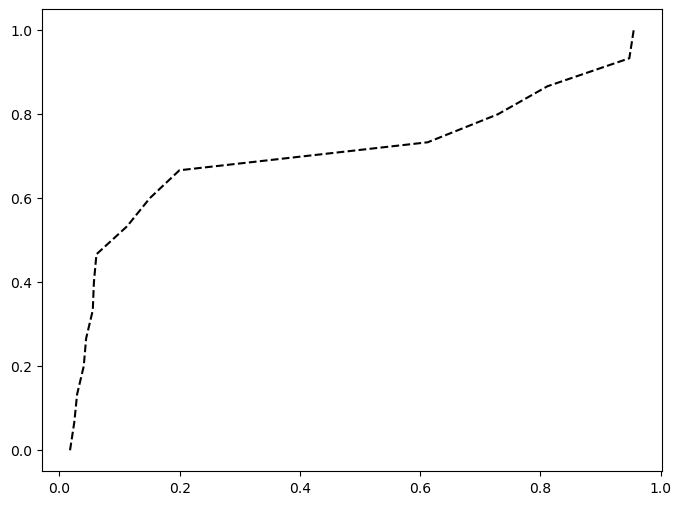

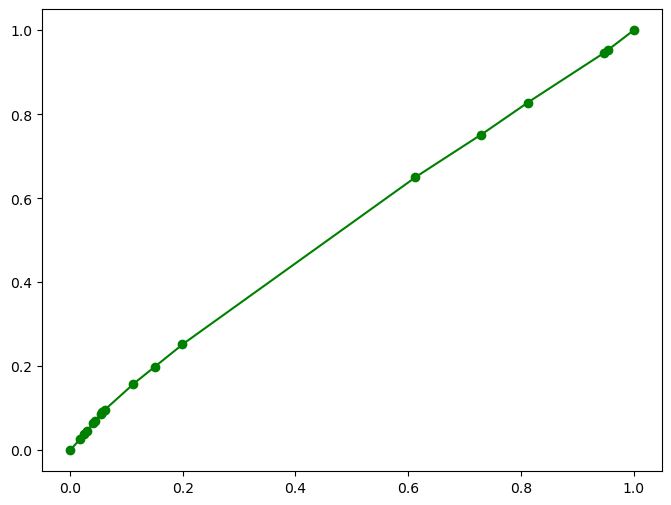

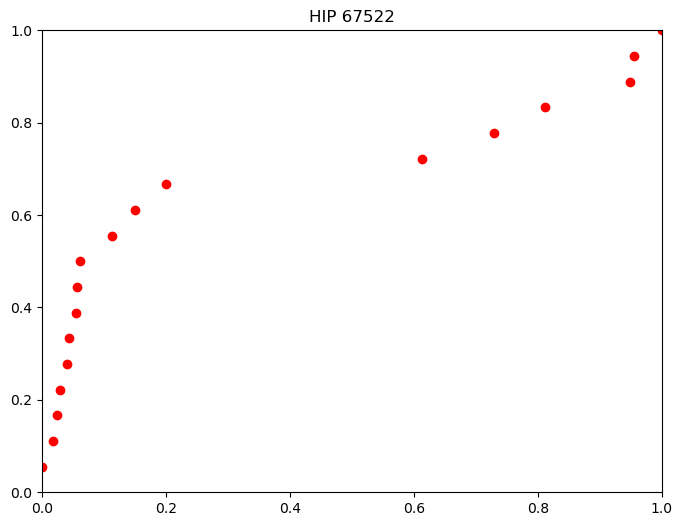

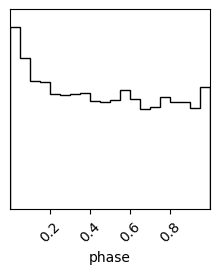

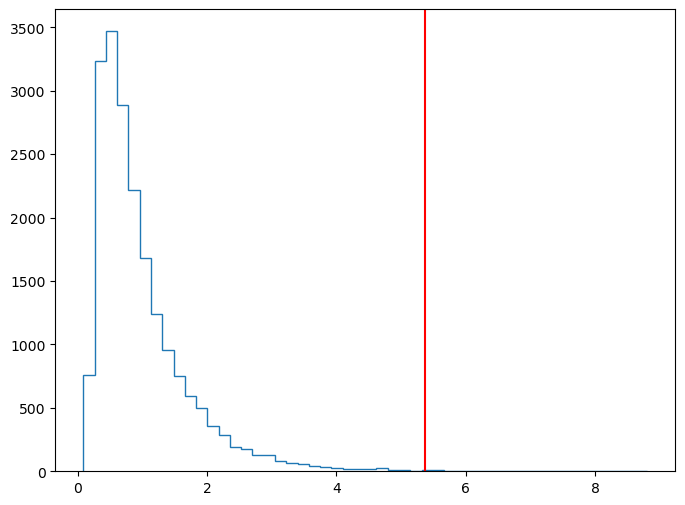

In [35]:
phaseshifts = [0.,0.,0.,0.]
pvals = []
pvalsks = []

for phaseshift in phaseshifts:



    df = pd.read_csv("../data/2022_07_flares_vetted.csv")
    cond = (df.ID == "HIP 67522") & (df.real == 1) & (df.mask_pos_outliers_sigma>1.5)
    tessps = ((df[cond].tstart + 2457000 - midtime + phaseshift*period ) % period / period ).values #+ phaseshift*period
    tesslc = df[cond].qcs.values

    cheopsps = (cheopsflares["phase"].values + phaseshift) % 1
    cheopslc = [1,1,1,1]

    pss = np.concatenate([tessps, cheopsps])
    lcc = np.concatenate([tesslc, cheopslc])

    # pss = tessps
    # lcc = tesslc

    ps, bins = get_observed_phases(np.sort(pss), lcs, [2,2,2,10./60.], [11, 38, 64,1], phaseshift=phaseshift)#

    F_k_cheops = 12 / ps[[11, 38, 64]].sum().sum() * ps[1].sum()

    # sum ps in each lc
    print("Obs time")
    print(ps.sum(axis=0))



    df = pd.DataFrame({"phases": pss, "qcs": lcc})

    n_i, n_exp, cum_n_exp, cum_n_i = get_cumulative_distributions(df, ps, [11, 38, 64, 1], F_k_cheops=F_k_cheops)

    # plt.plot(cum_n_i, cum_n_exp)
    plt.figure(figsize=(8,6))
    plt.plot(np.sort(pss), np.linspace(0,1,len(pss)), "k--")

  
    p = np.sort(pss)
    p = np.insert(p,0,0)
    p = np.append(p,1)


  
    cum_n_exp = np.insert(cum_n_exp, 0, 0)
    # cum_n_exp = np.append(cum_n_exp, 1)

    # print(cum_n_exp)
    # print(p)
    # print(cum_n_i)
    cum_n_i = np.insert(cum_n_i, 0, 0)

    plt.figure(figsize=(8,6))
    plt.plot(p, cum_n_exp, "o", color="green")

    # plt.plot(p, cum_n_i, "o", color="red")

    f = interpolate.interp1d(p, cum_n_exp, fill_value="extrapolate")
    ph = np.linspace(0,1,1000)
    plt.plot(ph, f(ph), c="green")


    N =20000
    # Make a diagnostic plot
    plt.figure(figsize=(8,6))
 
    # plt.plot(p,f(p), c="green")
    dsave = pd.DataFrame({"p":p, "f":f(p)})
    dsave.to_csv(f"cumhist.csv",
                    index=False)
    cumsum =  np.cumsum(np.ones_like(p)) / len(p)
    plt.scatter(p, cumsum, c="r")
    plt.title(f"HIP 67522")
    plt.xlim(0,1)
    plt.ylim(0,1)
    # plt.savefig(f"../plots/cumhist.png")
    # plt.close()

    # Finally, run the A-D test
    print(p)
    print(f)
    A2 = sample_AD_for_custom_distribution(f, p.shape[0], N)

    # This should go into the function above
    # select only the finite values
    print(np.isfinite(A2).sum(), A2.shape)
    A2 = A2[np.isfinite(A2)]

    plt.figure(figsize=(8,6))   
    plt.hist(A2, bins=50, histtype="step")

    # Calculate the p-value and A2 value using the distribution 
    # of A2 values
    pval, atest = get_pvalue_from_AD_statistic(p, f, A2)
    plt.axvline(atest, color="red")
    print(pval, atest)
    pvals.append(pval)

    from scipy.stats import kstest

    ks = kstest(p, f, args=(), N=1000, alternative='two-sided', mode='approx')
    print(ks)
    pvalsks.append(ks.pvalue)


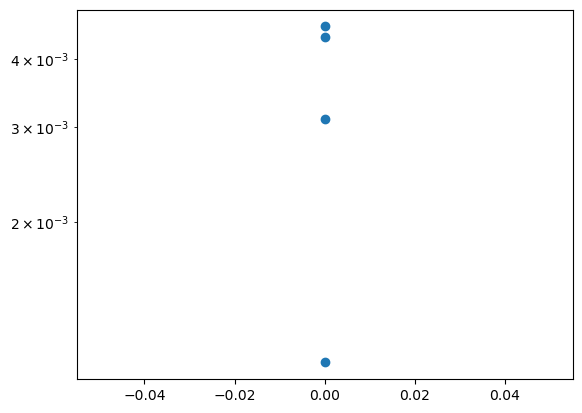

In [36]:
plt.scatter(phaseshifts, pvals)
plt.yscale("log")


In [37]:
print(pvalsks)
np.mean(pvalsks), np.std(pvalsks), np.median(pvalsks)

[0.0025845400520368754, 0.0025845400520368754, 0.0025845400520368754, 0.0025845400520368754]


(0.0025845400520368754, 0.0, 0.0025845400520368754)

In [38]:
np.median(pvals), np.mean(pvals), np.std(pvals)

(0.00375, 0.0032999999999999826, 0.0013946325680982067)

ADtest|median|mean|std|
|---|------|-----|------|
TESS+CHEOPS|0.054699999999999985|0.05774999999999991|0.025265539772583508|
TESS|0.09829999999999983|0.1327749999999999|0.12952469600427557|
CHEOPS only | 0.2562| 0.29305000000000003| 0.11491428327235916|
TESS nophase|0.0071999999999999885| 0.0072749999999999915| 0.002038841582860305|
TESS+CHEOPS nophase|0.06125|0.07072499999999998|0.020573207698363388|


KStest pval

TESS+CHEOPS nophase: 0.024159807259394334

TESS+CHEOPS: 0.15159662337119817, 0.17928635091400993, 0.06451225110086192

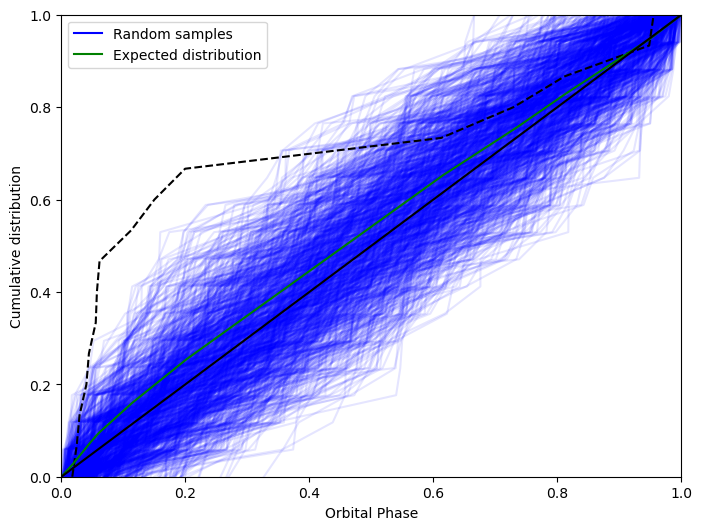

In [43]:
# read samples.npy
samples = np.load("samples.npy")

samples.shape

# plot a random subset of the samples as a cumulative histogram
plt.figure(figsize=(8,6))
for i in range(1000):
    plt.plot(np.sort(samples[i]), np.linspace(0,1,len(samples[i])), alpha=0.1, color="blue")
plt.plot(np.sort(pss), np.linspace(0,1,len(pss)), "k--")

# plot f(p) as a green line 
f = interpolate.interp1d(p, cum_n_exp, fill_value="extrapolate")
ph = np.linspace(0,1,1000)
plt.plot(ph, f(ph), c="green")

# plot the 1-1 line
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), "k")

plt.xlim(0,1)
plt.ylim(0,1)

plt.ylabel("Cumulative distribution")
plt.xlabel("Orbital Phase")

# make legend handles with 1D line objects
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Random samples')
green_line = mlines.Line2D([], [], color='green', label='Expected distribution')
black_line = mlines.Line2D([], [], color="k", label="1-1 line")
plt.legend(handles=[blue_line, green_line])

In [17]:
1e5/60/24, 1e4/60/24

(69.44444444444444, 6.944444444444444)

In [32]:
(100-99.7)/100

0.0029999999999999714

In [33]:
pvals

[0.0043000000000000685,
 0.08079999999999984,
 0.03180000000000007,
 0.003100000000000023]